# Capstone Project:
# Model Evaluation

## Imports

In [2]:
import numpy as np
import pandas as pd
import os
import string
import pickle
import math
import pydot
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, Bidirectional, Embedding
from keras.layers.merge import add
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers, optimizers
from nltk.translate.bleu_score import sentence_bleu

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

/Users/yannusinovich/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yannusinovich/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yannusinovich/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yannusinovich/opt/anaconda3/lib/python3

## Reload Model

In [3]:
def load_obj(name):
    with open('../Obj/' + name + '.pickle', 'rb') as f:
        return pickle.load(f)
    
vocab = load_obj("vocab")

In [4]:
vocab_size = len(vocab) + 1

In [5]:
pre_model = InceptionV3(weights = 'imagenet')
new_model = Model(pre_model.input, pre_model.layers[-2].output)

In [6]:
image_dict = dict()

for filename in os.listdir("../Data/Test_Photos/"):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"): 
        image_path = os.path.join("../Data/Test_Photos/", filename)
        # Convert all the images to size 299 x 299 as expected by the InceptionV3 Model
        img = image.load_img(image_path, target_size = (299, 299))
        # Convert PIL image to numpy array of 3-dimensions
        x = image.img_to_array(img)
        # Add one more dimension
        x = np.expand_dims(x, axis = 0)
        # preprocess images using preprocess_input() from inception module
        x = preprocess_input(x)
        feature = new_model.predict(x, verbose = 0)
        feature = np.reshape(feature, feature.shape[1])
        image_number = int(filename.split(".")[0])
        image_dict[image_number] = feature

In [7]:
index_to_word = {}
word_to_index = {}
index = 1
for word in vocab:
    word_to_index[word] = index
    index_to_word[index] = word
    index += 1

In [8]:
max_length = 40

In [9]:
model = load_model("../Obj/final_model.h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Predict Test Captions

In [10]:
def captionGenerator(a_photo, a_randomness):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen = max_length)
        yhat = model.predict([a_photo, sequence], verbose = 0)
        yhat = np.random.choice((-yhat).argsort(axis = -1)[:, :a_randomness][0])
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [11]:
caption_df = pd.DataFrame(columns = range(1,21), index = range(0,26))
for rand_vals in range(1,21):
    for photo_num, photo_data in image_dict.items():
        caption_df.loc[photo_num, rand_vals] = captionGenerator(photo_data.reshape(1,2048), rand_vals)
caption_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,the worlds largest model model museum is home ...,the largest manmade excavation and the most au...,this collection includes unique objects from d...,this collection includes unique medium store s...,the ruins in this historic crypt was used for ...,museum dedicated entirely to one killer sighti...,an annual art art gallery and home for the bon...,of and an american dairy farm built with an ec...,collection celebrating and history and art by ...,in northeastern new yorks oldest street has al...,and only known by the man mouse skeleton bones...,collection that steps back back on display and...,the remains fathers who moved during mussolini...,and built by man king nelson to an annual role...,most museum from both history of color france ...,is all at place at place as place and home bef...,of bricabrac motion force force training now t...,stone towers carved in milwaukee village in th...,an old quarter built and in rural california c...,this historic tower of spanish cinema built du...
1,the worlds largest model model museum is home ...,and victor and built by the dead flesh stare i...,the ruins are home to one kilometer of egypts ...,the remains where moses has the and of an ecce...,museum devoted dedicated entirely from to life...,collection devoted by the history in the count...,art museum in all that has the oldest continuo...,an accidental doctors in the and of this strat...,art museum of curiosities curios spiders galor...,ruins in an old world themed museum featuring ...,museum and collection from oddities antiques c...,the selfmade hotel was constructed in its kind...,this statue depicts and his death were turned ...,this ancient village boasts an oddities specim...,an geologic objects in one hundred whirling st...,stone sculptures including its shelves in one ...,this an antique and museum tells an view out b...,giant light museum built in unique collection ...,this statue commemorates and his and son josep...,soul in modern city filled by globe of an aeri...
2,the worlds largest model model museum is home ...,and victor and son joseph smith to be the worl...,the ruins that has become an infamous survivor...,of the and the history that was constructed by...,this the site in this ohio brooklyn islands la...,the remains in the city that has an important ...,of this historic cemetery now hosts urban marv...,museum of bricabrac history including taxiderm...,and and built built and the hunt that is actua...,this abandoned mine fort built entirely from g...,this small patch in england in the world in ir...,stone age art store is home via by its related...,collection celebrating the life with machines ...,of the great archipelago forests with mummy th...,museum on street and the ruins at st capital a...,stone windows to one museum and retail shop is...,in rural sweden with of and and mediums that t...,of one the oldest chinese cathedral outside st...,natural color and history created in one baske...,natural hot springs for antique memorabilia cr...
3,the worlds largest model model museum is home ...,and an abandoned mine in the world of this old...,the oldest continuously occupied prison in eur...,an annual festival in the netherlands in rural...,an ancient temple to be the home to some the f...,this ancient temple has an old church with box...,collection that has the remains of one the lar...,of and kitsch created by the stars that have h...,collection in this museum of art in this old w...,worlds biggest portrait is said for the and is...,home by an important chocolate crab in an enti...,of billy an artists dream collective emporium ...,worlds radioactive storage theatre of antique ...,stone tower and built entirely to the ocean in...,worlds fair excavated an collection and librar...,museum that made is one and an austrian house ...,collection including antique equipment created...,of modern mummification structures found the w...,museum celebrating art from and manuscri

## Load Actual Captions and Calculate Bleu Scores

In [12]:
bleu_df = pd.DataFrame(columns = range(1,21), index = range(0,26))
actual_caption_df = pd.read_csv("../Data/Test_Captions.csv")
actual_caption_df.drop(columns = "Filename", inplace = True)
for i in caption_df.index:
    for j in caption_df.columns:
        bleu_df.loc[i,j] = sentence_bleu(actual_caption_df.loc[i,"Caption"], caption_df.loc[i,j], weights=(1, 0, 0, 0))
bleu_df


/Users/yannusinovich/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/yannusinovich/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/yannusinovich/opt/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.100457,0.0986547,0.0913043,0.0830189,0.105769,0.0795455,0.108911,0.0941704,0.092437,0.0990566,0.0960699,0.0866142,0.101382,0.104762,0.0990991,0.100962,0.100962,0.100457,0.100917,0.0901288
1,0.088785,0.0976744,0.1,0.0884956,0.0854701,0.107692,0.0934579,0.0823045,0.0729927,0.0972222,0.0820313,0.0929204,0.0875576,0.0798479,0.097561,0.0886076,0.0995261,0.0958904,0.0790514,0.0904762
2,0.0888889,0.0881057,0.0959596,0.0900474,0.0896226,0.105263,0.0826087,0.0873362,0.087963,0.0809717,0.0931373,0.0847458,0.0896861,0.0952381,0.0925926,0.0995025,0.0891089,0.0904762,0.0837004,0.0769231
3,0.087963,0.0913242,0.0840708,0.08867,0.0934579,0.0970874,0.0877193,0.0934579,0.0990099,0.0990099,0.0900901,0.0869565,0.0896861,0.0925926,0.0809717,0.0913242,0.0854701,0.0829876,0.083682,0.078125
4,0.0909091,0.0722433,0.0560472,0.0746888,0.0849057,0.0917874,0.0865801,0.0847458,0.0882353,0.0913242,0.1,0.0935961,0.0961538,0.0801688,0.0769231,0.0904762,0.10101,0.0925926,0.0952381,0.077821
5,0.0929204,0.0938967,0.0847458,0.0956522,0.0887097,0.0893617,0.0813008,0.106796,0.0986547,0.0852713,0.0969163,0.0995475,0.0881057,0.0852713,0.0849421,0.0860656,0.100962,0.0977778,0.0995261,0.093617
6,0.08,0.0929204,0.0938967,0.0893617,0.0878661,0.0853659,0.0896861,0.0963303,0.093617,0.0981308,0.0850202,0.100917,0.0944206,0.107843,0.0792453,0.0963303,0.0929204,0.0921053,0.0956522,0.0860656
7,0.0958904,0.10396,0.113402,0.0917031,0.0789474,0.0977778,0.0819672,0.0973451,0.0909091,0.100457,0.0742049,0.0991379,0.0875,0.0929204,0.102804,0.100457,0.0929204,0.0929204,0.0932203,0.092437
8,0.101449,0.09375,0.105,0.0977778,0.109524,0.0897436,0.0948276,0.100478,0.114428,0.101852,0.0972222,0.101322,0.1,0.100917,0.102804,0.105505,0.10628,0.0948276,0.107317,0.0905512
9,0.0913242,0.0934579,0.0878661,0.0961538,0.0909091,0.0974359,0.0985222,0.097561,0.0966184,0.0900901,0.0877193,0.0883721,0.0888889,0.0901288,0.0840336,0.0925926,0.0854701,0.0917874,0.0909091,0.0881057


In [14]:
avg_bleu_df = pd.DataFrame(columns = range(1,21), index = ["avg"])
for j in bleu_df.columns:
    avg_bleu_df.loc["avg",j] = bleu_df.loc[:,j].mean()
avg_bleu_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
avg,0.0848463,0.0865247,0.0860433,0.0874582,0.0862237,0.0892166,0.0861743,0.0878303,0.0876543,0.0867335,0.0856098,0.0885574,0.0897641,0.0886392,0.0848142,0.0868849,0.0870038,0.0893039,0.0862311,0.0845128


In [15]:
avg_bleu_df.loc["avg",:]

1     0.0848463
2     0.0865247
3     0.0860433
4     0.0874582
5     0.0862237
6     0.0892166
7     0.0861743
8     0.0878303
9     0.0876543
10    0.0867335
11    0.0856098
12    0.0885574
13    0.0897641
14    0.0886392
15    0.0848142
16    0.0868849
17    0.0870038
18    0.0893039
19    0.0862311
20    0.0845128
Name: avg, dtype: object

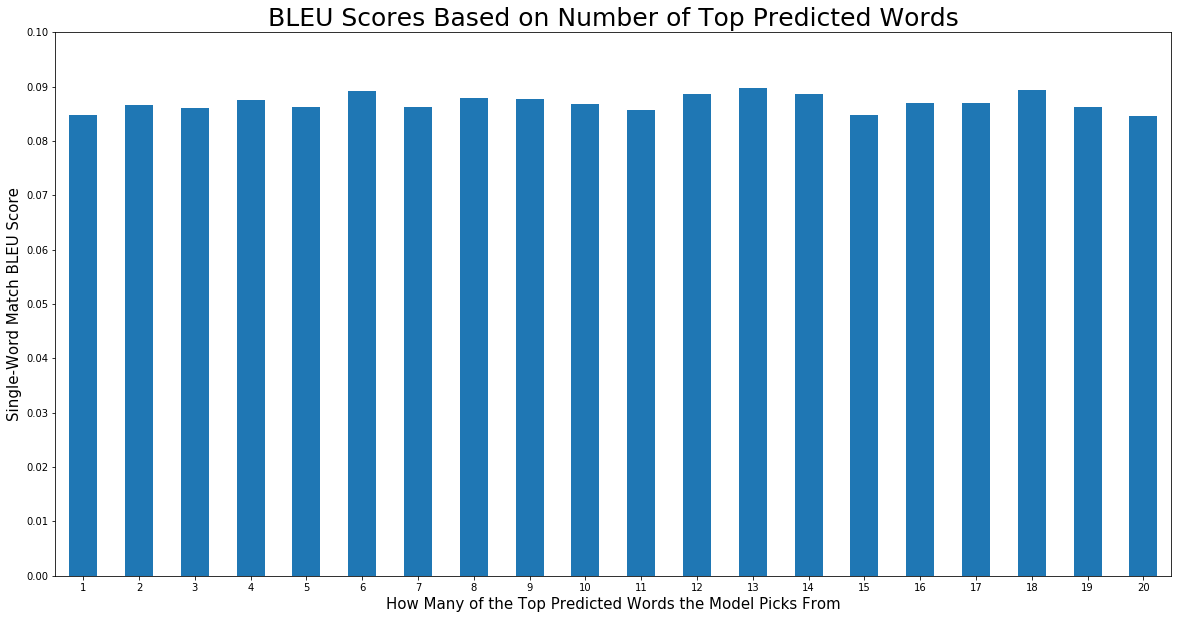

In [95]:
ax = avg_bleu_df.loc["avg",:].plot(kind = "bar", legend = False, figsize = (20,10))
plt.xlabel("How Many of the Top Predicted Words the Model Picks From", fontsize = 15)
plt.ylabel('Single-Word Match BLEU Score', fontsize = 15)
plt.yticks(np.arange(0,.11,.01))
plt.xticks(rotation = "horizontal")
plt.title('BLEU Scores Based on Number of Top Predicted Words', fontsize = 25)
plt.show();

## Review Most Popular Words with No Randomness

In [21]:
for i in range(len(caption_df.loc[:,1])):
    print("Caption number " + str(i) + ": " + caption_df.loc[i,1])

Caption number 0: the worlds largest model model museum is home to the worlds most famous flowers and the remains of the worlds largest model of egypts egypts and the dead flesh of the shooting bug lovecraft and the occasional hungry and
Caption number 1: the worlds largest model model museum is home to the worlds most famous flowers and the remains of the worlds largest model of egypts egypts and the regions and the worlds largest model of egypts history of the boy
Caption number 2: the worlds largest model model museum is home to the worlds most famous flowers and the remains of the worlds largest model of egypts egypts and the dead flesh of the shooting bug lovecraft and the occasional contraptions and
Caption number 3: the worlds largest model model museum is home to the worlds largest model of egypts history and orleans and patriotism of the french poet and the dead flesh of the proportions and of the proportions and of the middle
Caption number 4: the worlds largest model model m

## Compare Most Popular Words Based on Randomness

In [42]:
caption_vocab = pd.DataFrame(columns = range(1, 21), index = ["vocab"], data = np.empty((1, 20), dtype = np.str))
caption_vocab
for i in range(0, 26):
    for j in range(1, 21):
        caption_vocab.loc["vocab", j] = caption_vocab.loc["vocab", j] + caption_df.loc[i, j]

In [43]:
caption_vocab

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
vocab,the worlds largest model model museum is home ...,the largest manmade excavation and the most au...,this collection includes unique objects from d...,this collection includes unique medium store s...,the ruins in this historic crypt was used for ...,museum dedicated entirely to one killer sighti...,an annual art art gallery and home for the bon...,of and an american dairy farm built with an ec...,collection celebrating and history and art by ...,in northeastern new yorks oldest street has al...,and only known by the man mouse skeleton bones...,collection that steps back back on display and...,the remains fathers who moved during mussolini...,and built by man king nelson to an annual role...,most museum from both history of color france ...,is all at place at place as place and home bef...,of bricabrac motion force force training now t...,stone towers carved in milwaukee village in th...,an old quarter built and in rural california c...,this historic tower of spanish cinema built du...


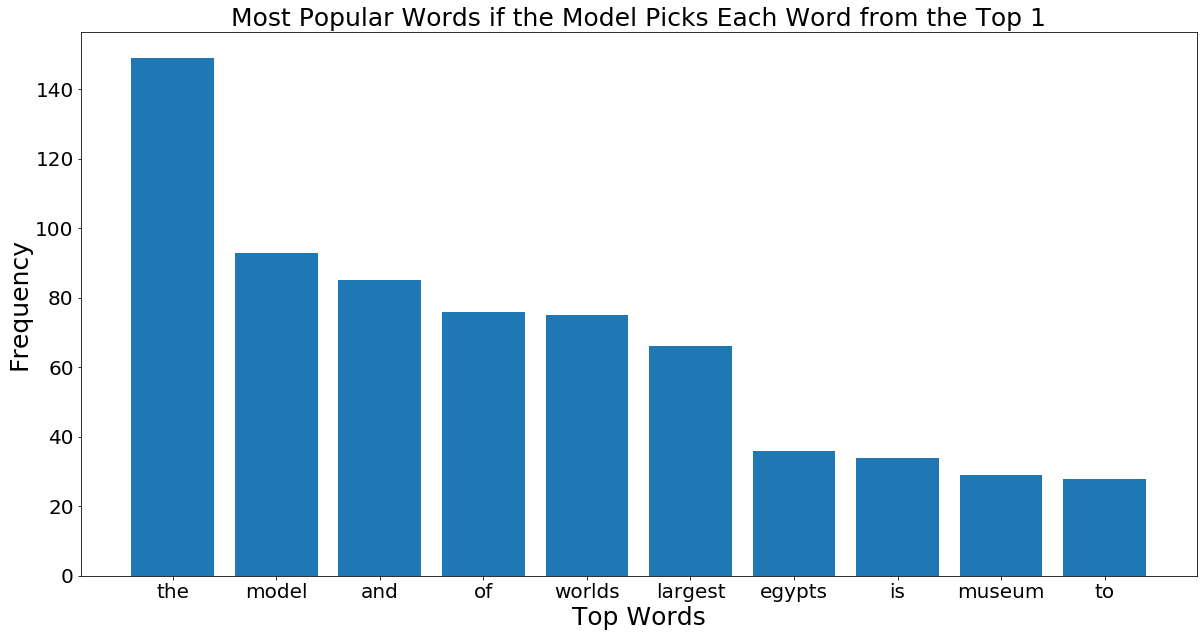

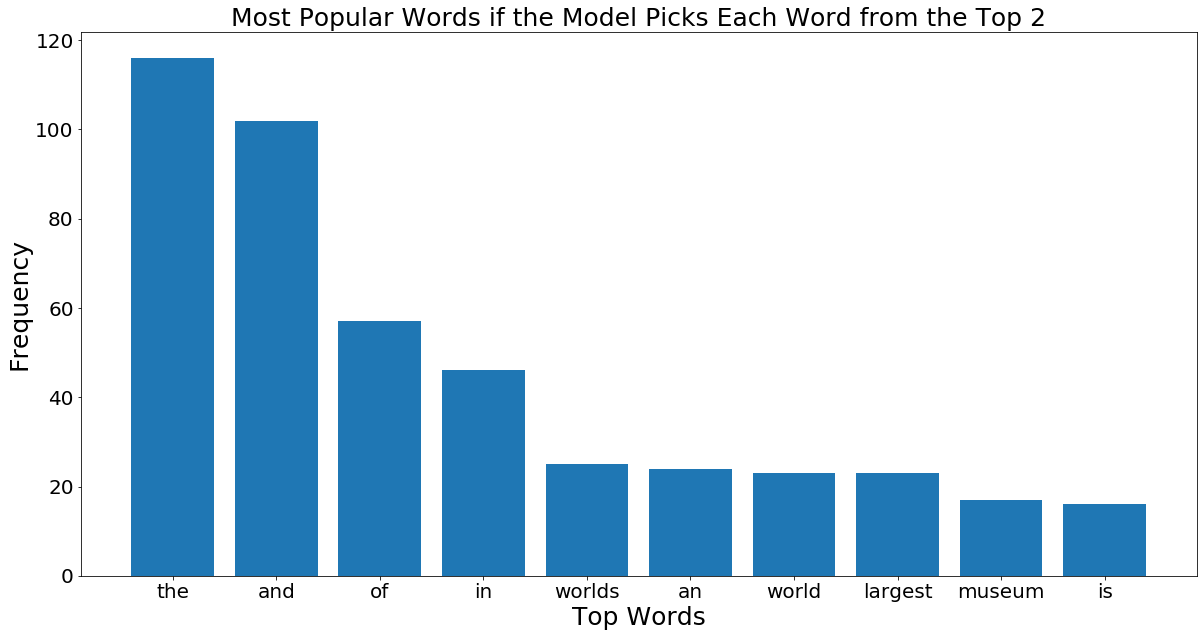

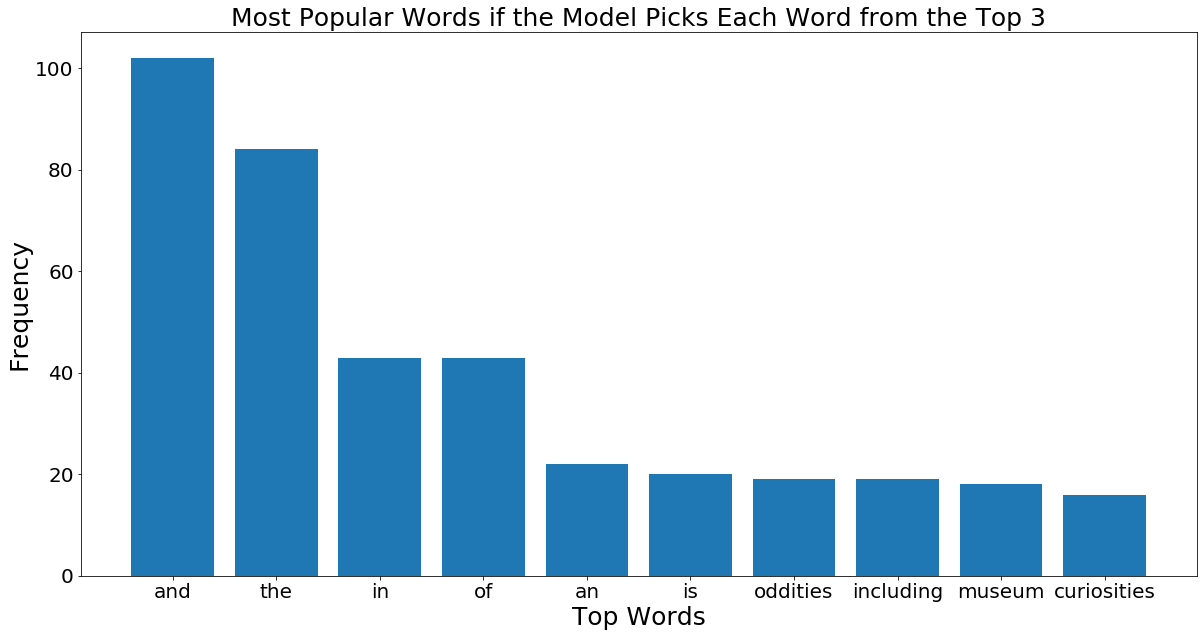

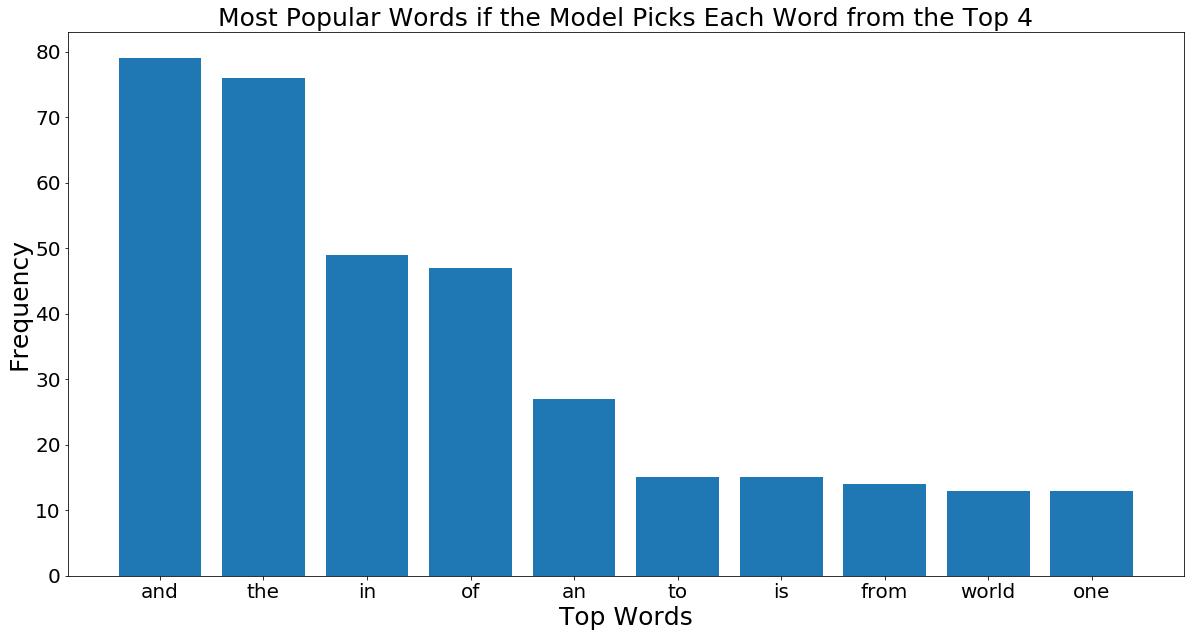

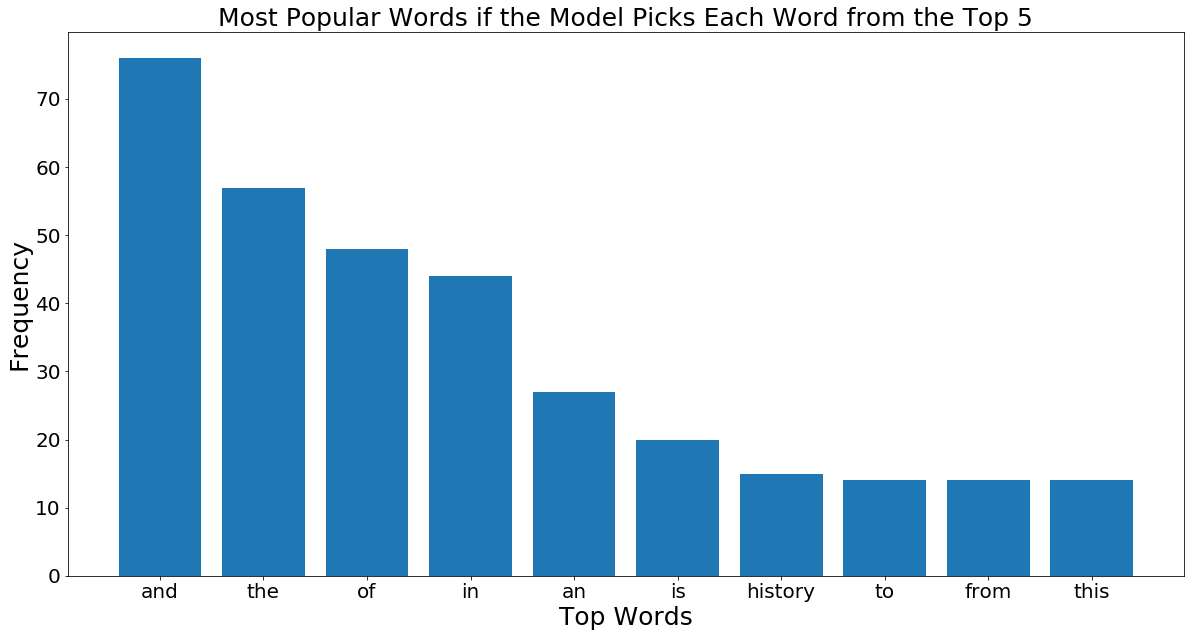

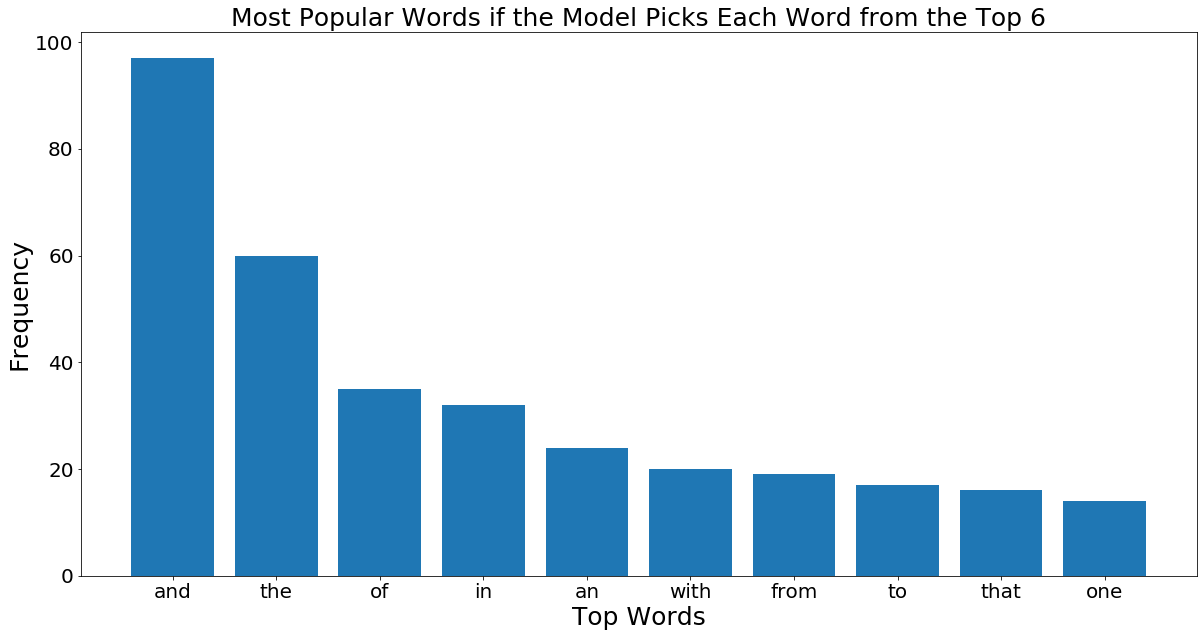

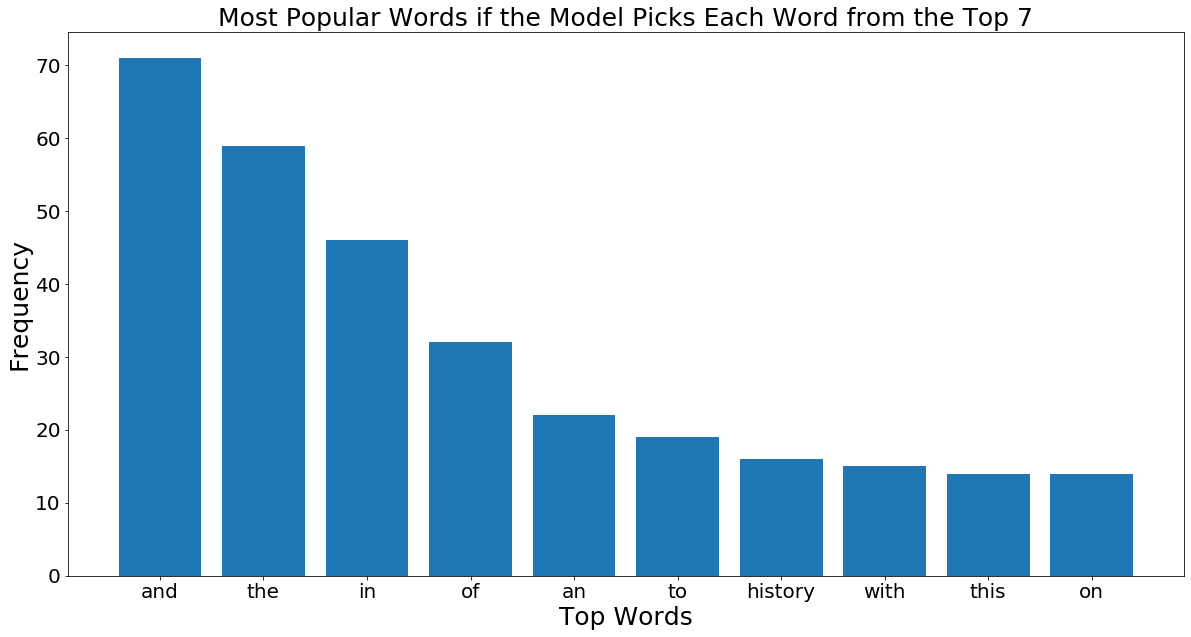

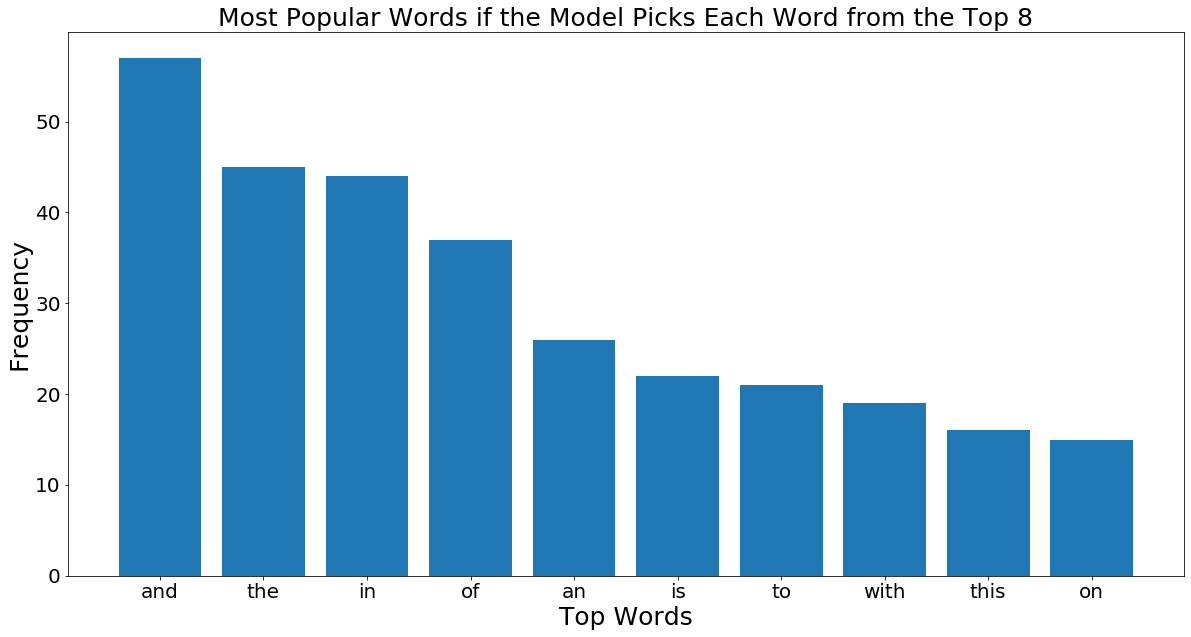

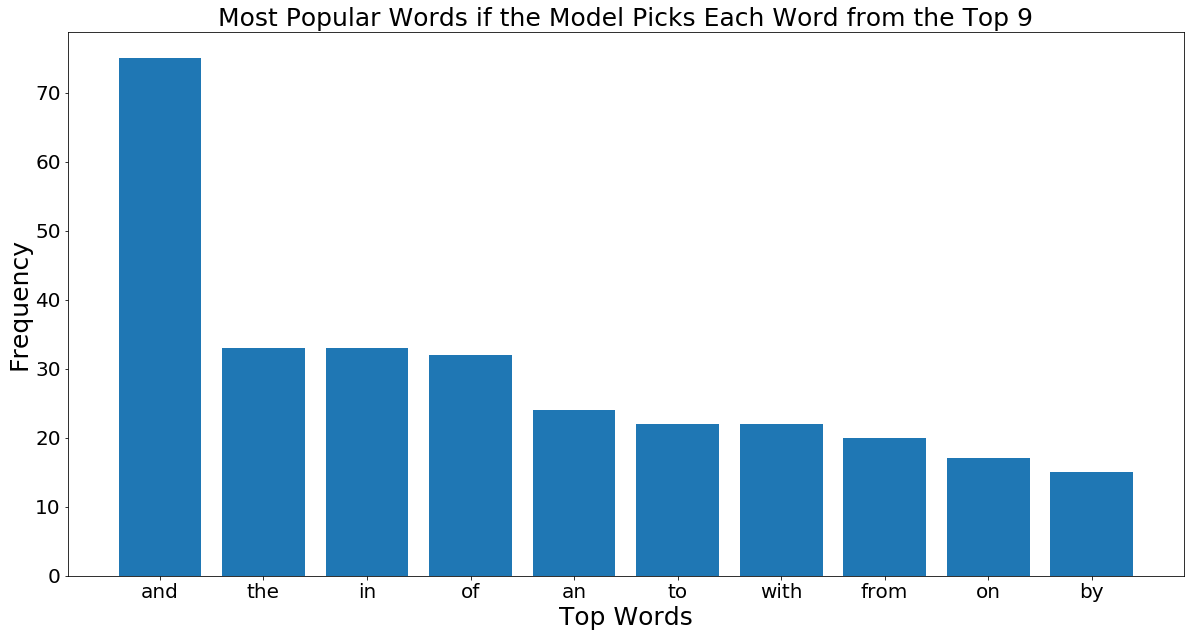

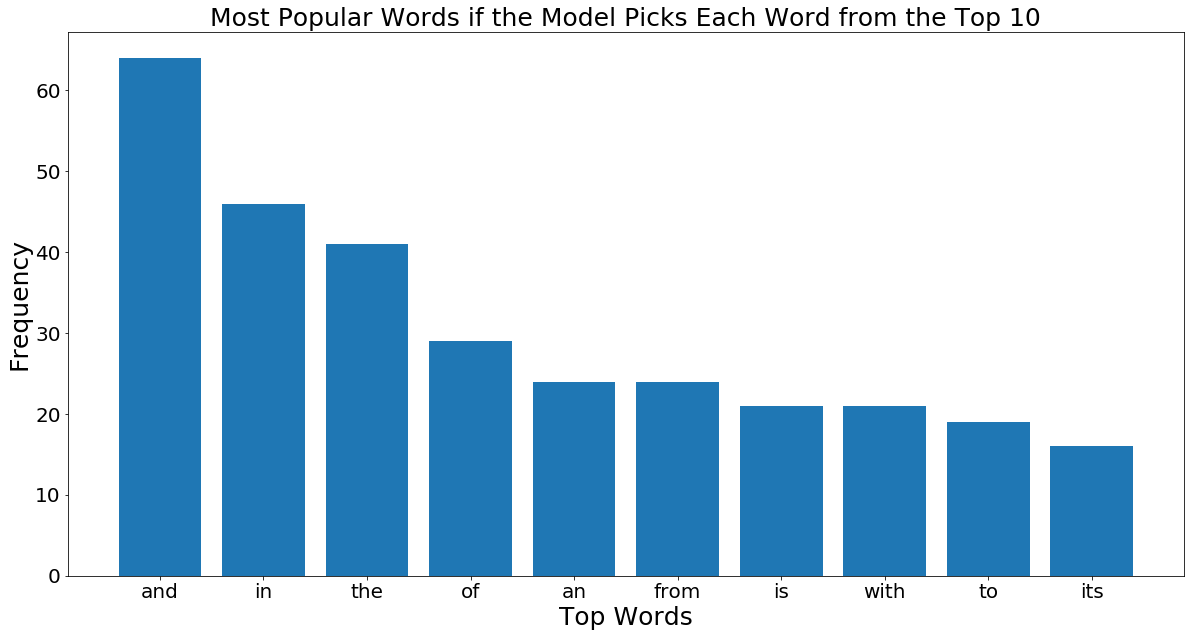

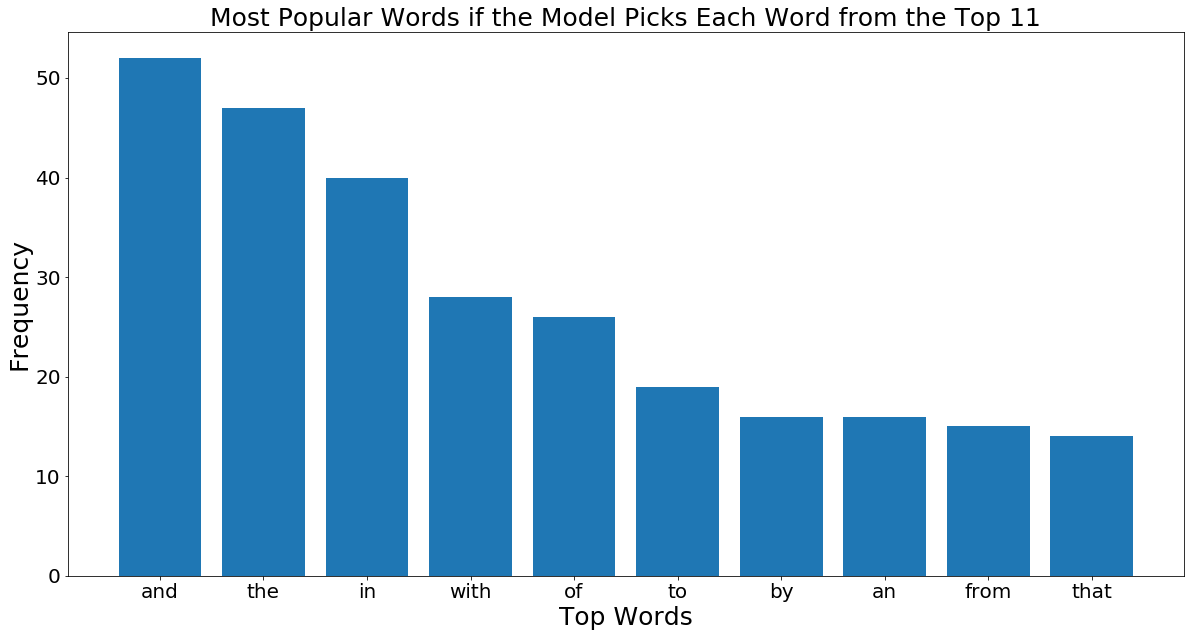

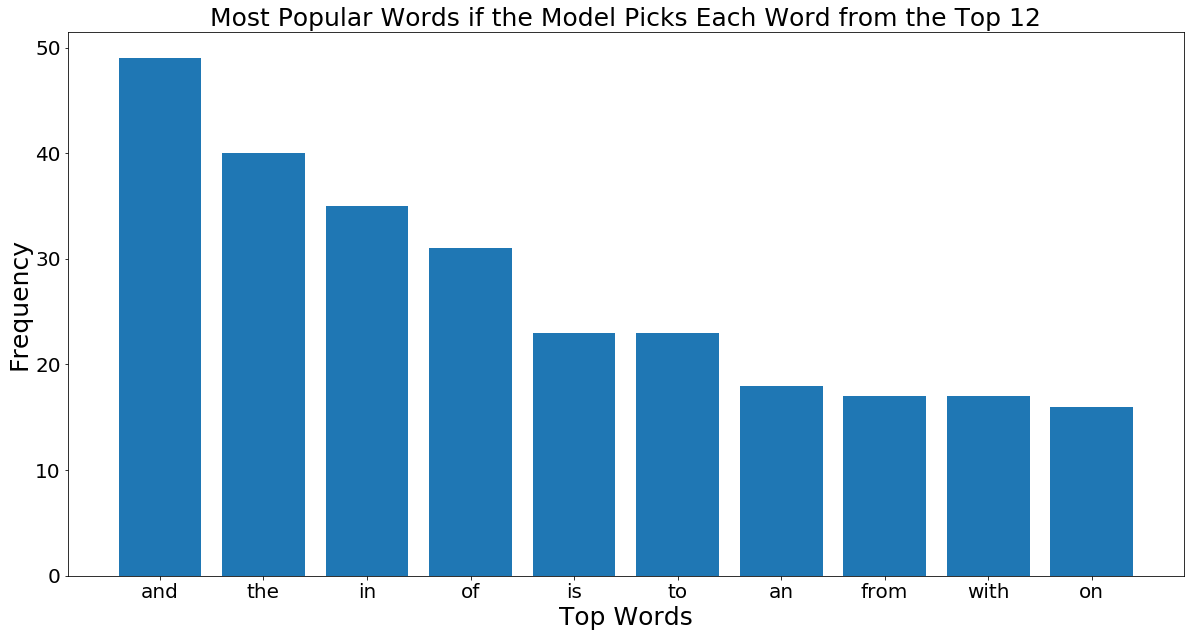

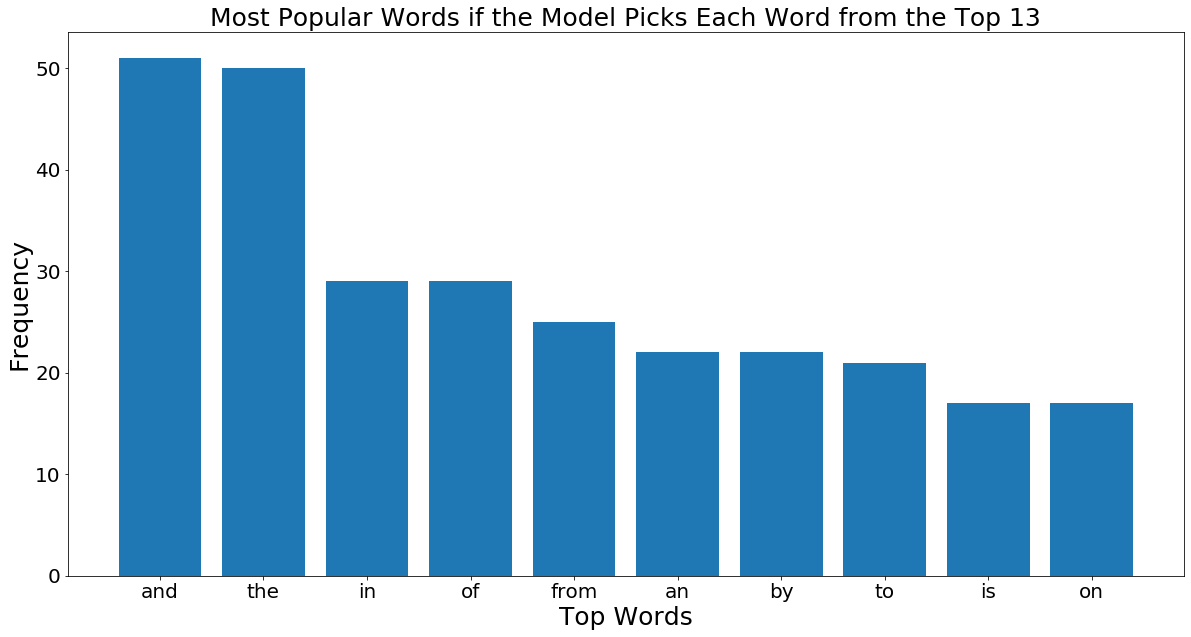

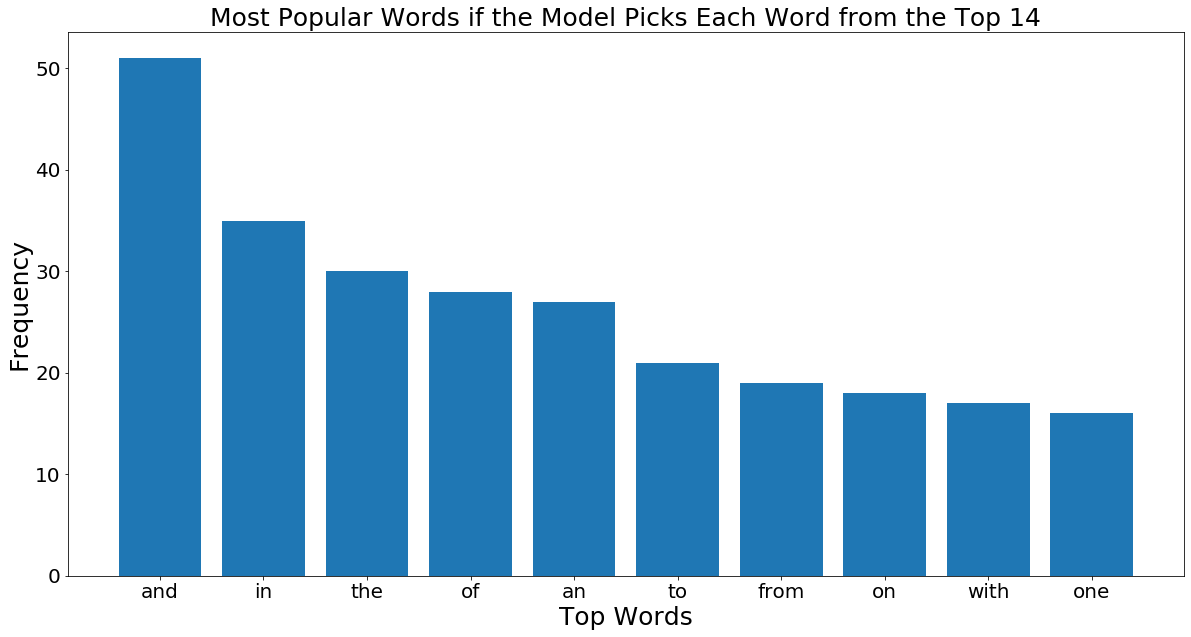

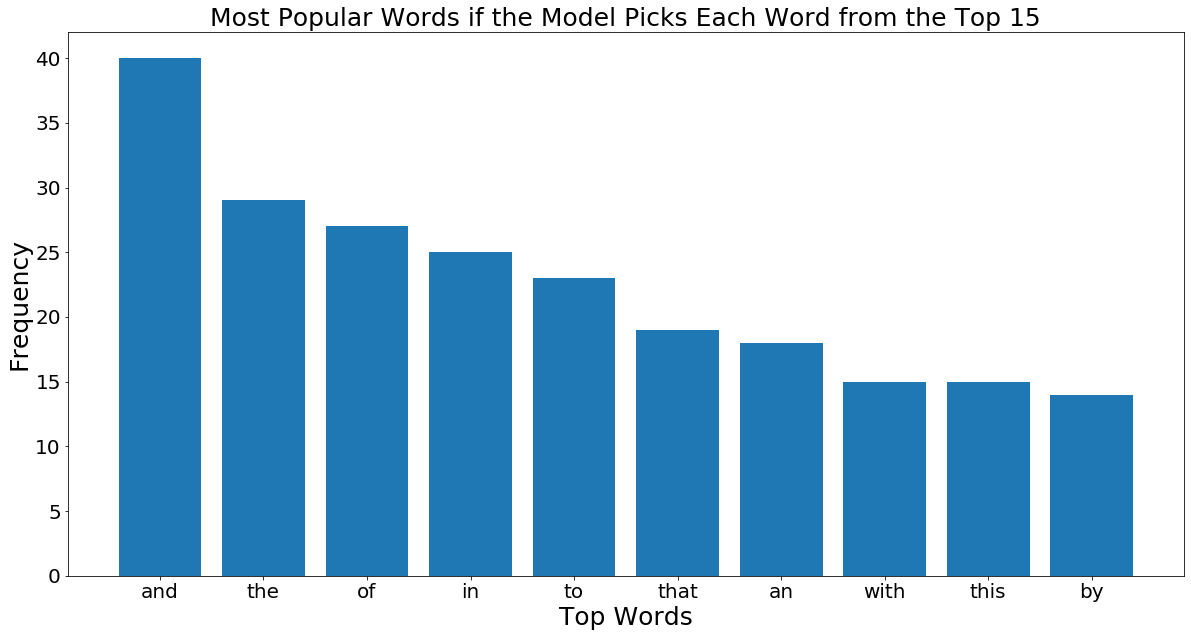

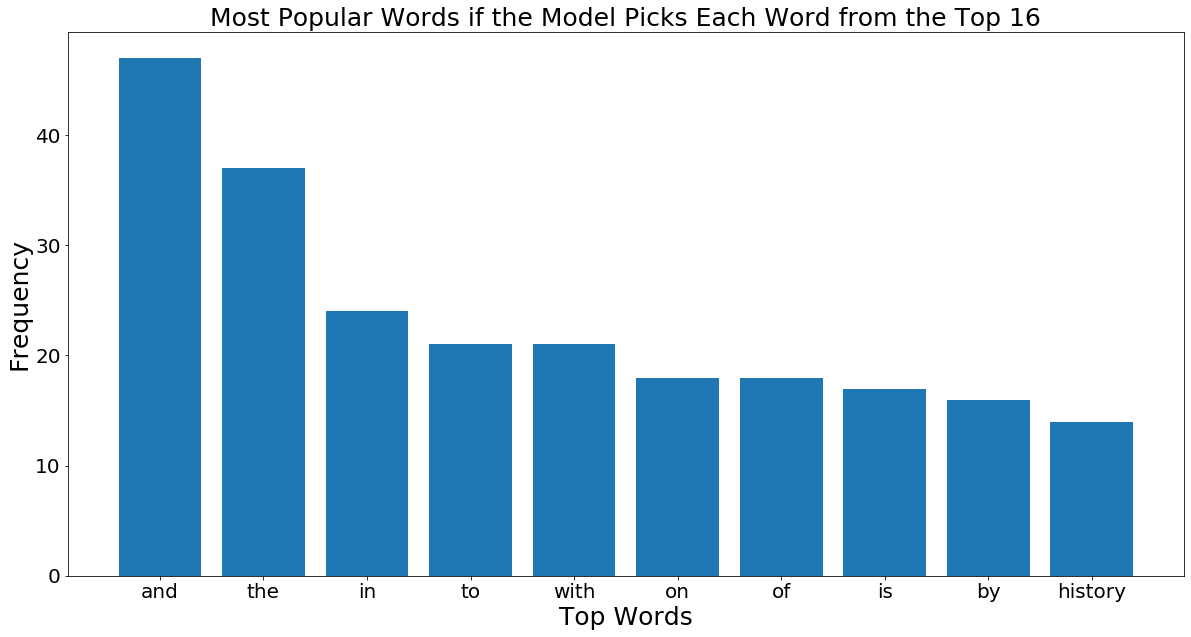

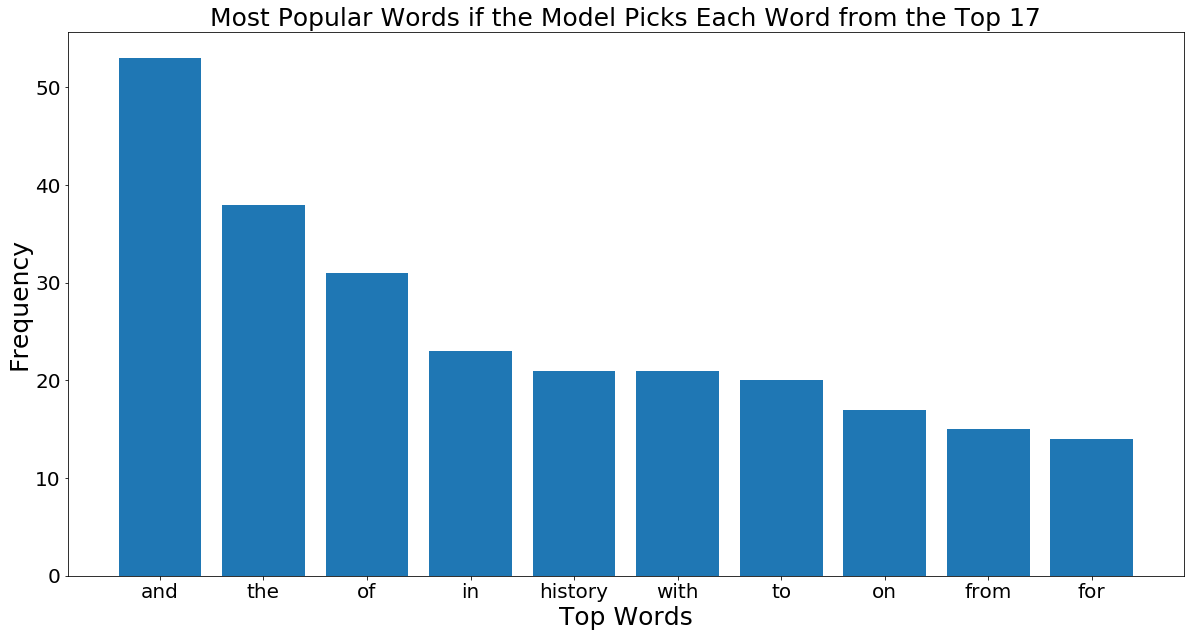

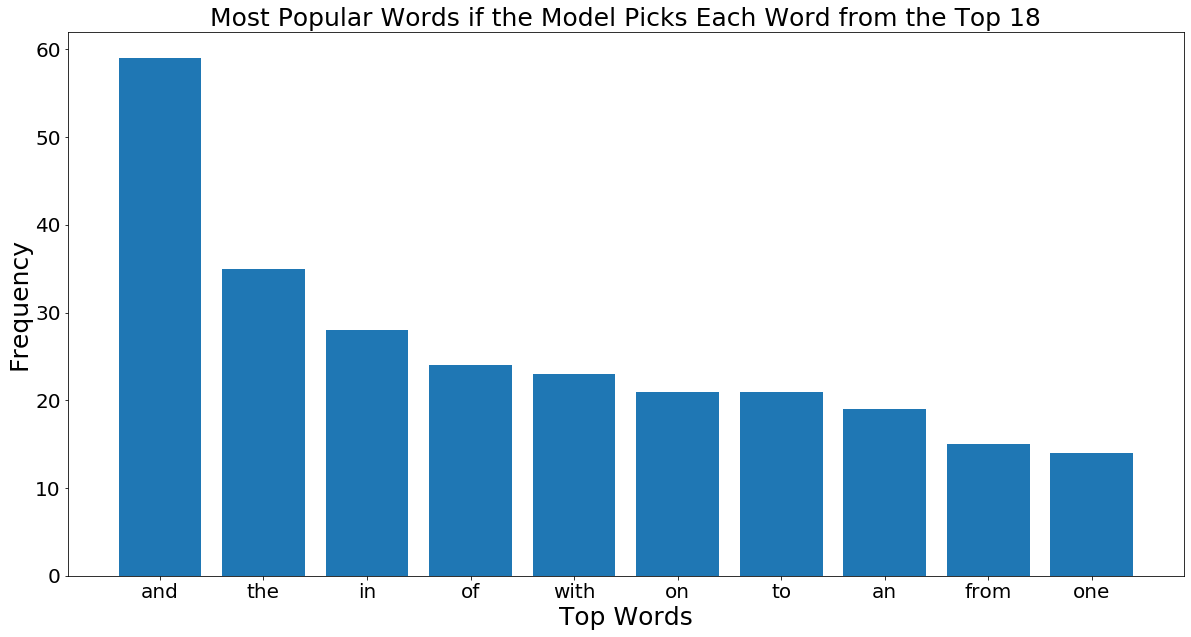

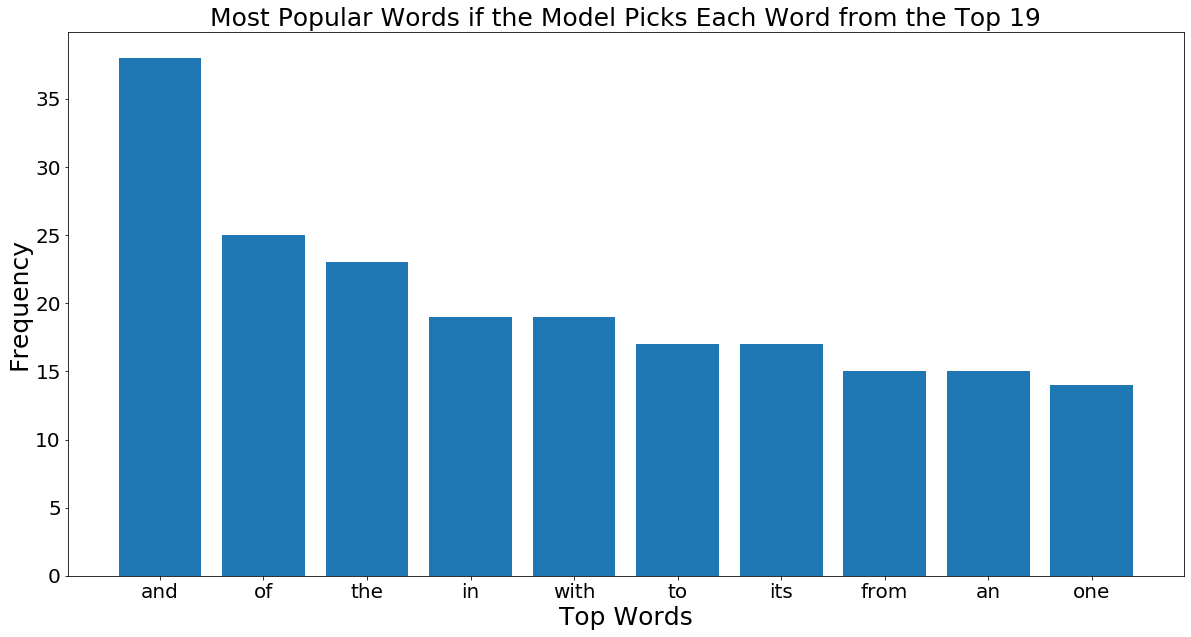

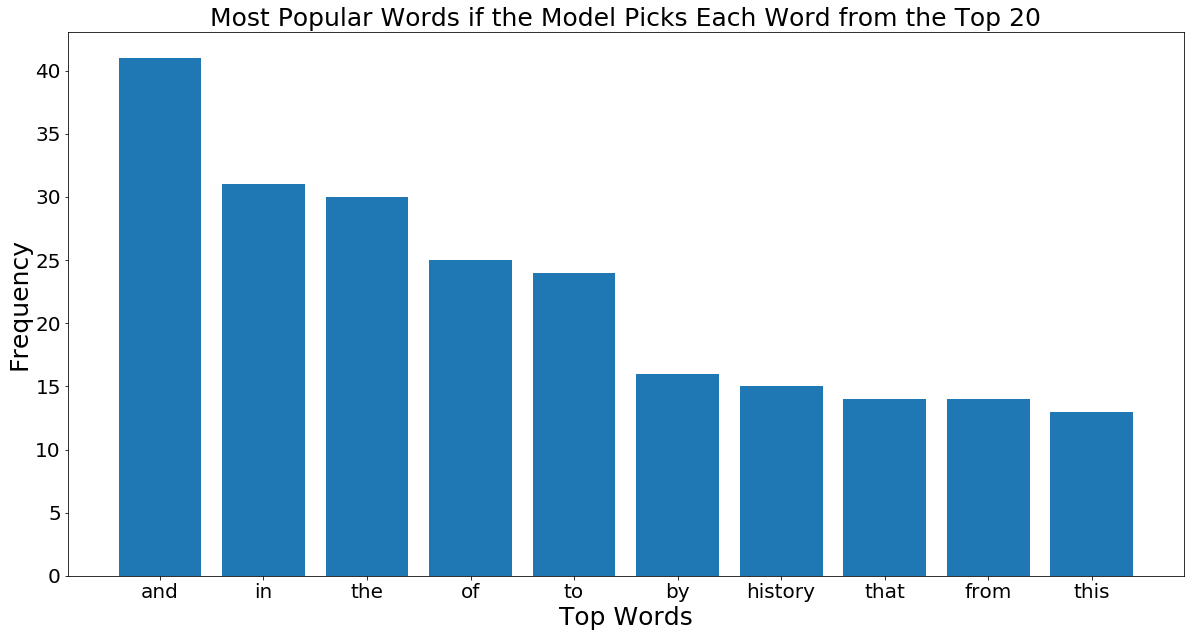

In [97]:
for j in np.arange(1,21):
    wordstring = caption_vocab.loc["vocab", j]
    wordlist = wordstring.split()
    wordfreq = [wordlist.count(w) for w in wordlist]
    word_df = pd.DataFrame(columns = ["words", "frequencies"])
    word_df.loc[:,"words",] = wordlist
    word_df.loc[:,"frequencies"] = wordfreq
    word_df.sort_values("frequencies", ascending = False, inplace = True)
    word_df.drop_duplicates(subset = "words", inplace = True)
    top_word_df = word_df.head(10)
    newwordlist = top_word_df.loc[:,"words"]
    newwordfreq = top_word_df.loc[:,"frequencies"]
    plt.figure(figsize=(20,10)) 
    plt.bar(newwordlist, newwordfreq)
    plt.xlabel("Top Words", fontsize = 25)
    plt.ylabel('Frequency', fontsize = 25)
    plt.xticks(rotation = "horizontal", fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.title(f'Most Popular Words if the Model Picks Each Word from the Top {j}', fontsize = 25)
    plt.show();